#Объект анализа

В рамках настоящей работы проведен анализ токена DJT
https://basescan.org/token/0xb7605fea8b810e39e8901f91b71f41760138d5da#balances


#1) Общий анализ токена



1) Токен не числится ни на одной крупной бирже, он есть только на агрегаторе DeFi бирж. Взглянем на график торгов, видим, что токен торговался всего несколько дней и цена с 0 разогнана до очень больших значений => почти наверное ненастоящая цена + ненастоящая капитализация. Сразу со старта несколько red flags.







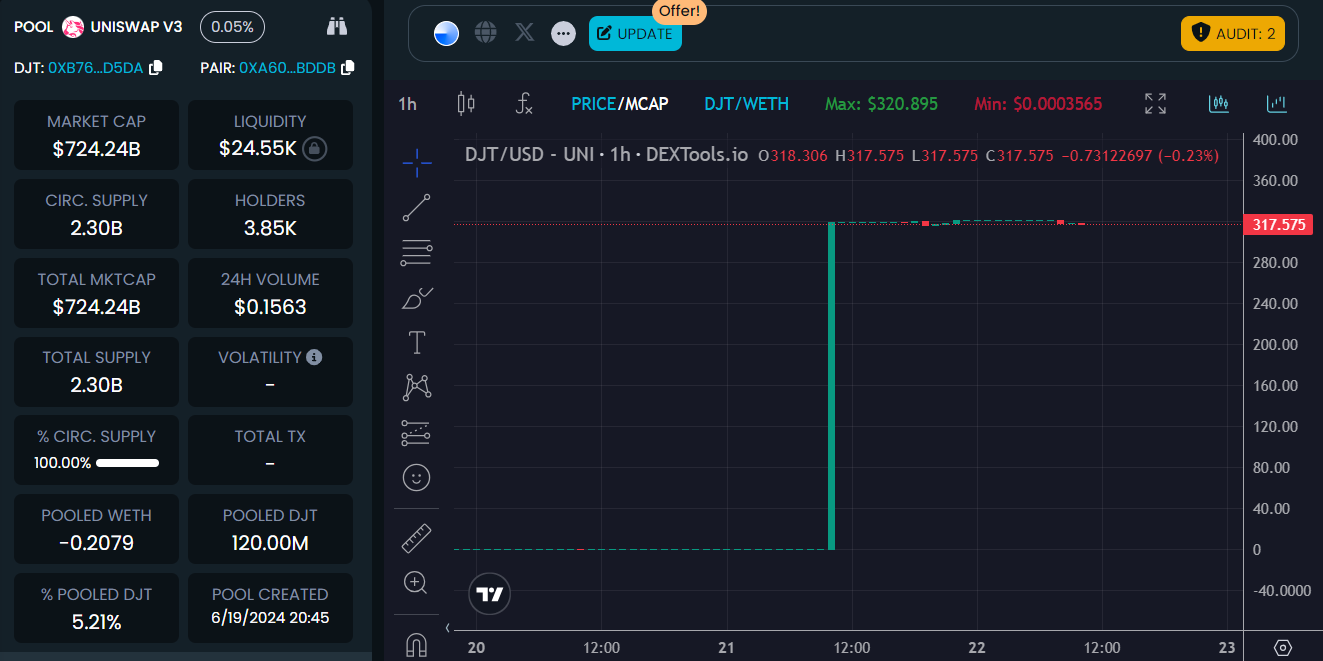

Разбираемся далее.
При помощи BaseScan смотрим топовых держателей токена. Видим, что 63% принадлежат всего лишь одному адресу - red flag. Данный адрес получил изначально 86% всех токенов от адреса создателя токена DJT - red flag.

Вернемся на биржу и взглянем на топовых трейдеров по данному токену.
Видно, что достаточно много топовых трейдеров продали за все время многократ больше токенов, чем получили. Обычно, когда трейдер продает больше, чем покупает - он получил ранее airdrop, но здесь airdrop слишком большой, это плохой знак.

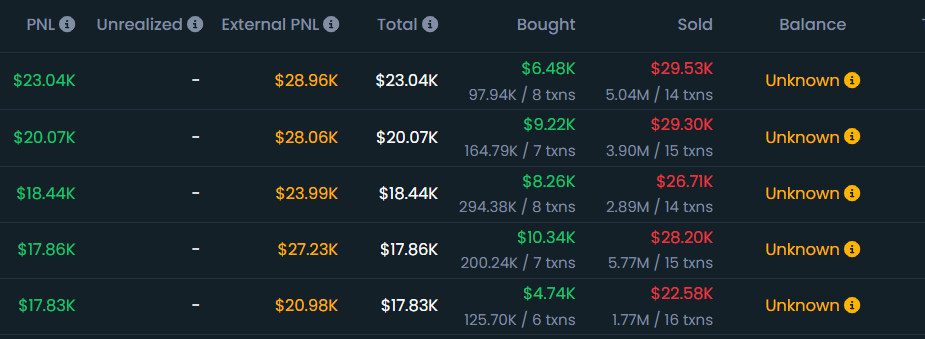

Разбираемся дальше. Находим данные адреса топ трейдеров с большим airdrop в BaseScan. Большая часть адресов приведенных в списке топовых трейдеров получила свои токены от адреса:

0x0dd20A60Fd2629E85E396Ce8ed13924443D4D51e

Который в свою очередь получил 2 миллиарда токенов от адреса:

0x3DC2be0779fbD2Acaf03FD894FfE9F3D2279216E

который является создателем нашего токена DJT.

Такие кошельки, как кошельки топовых трейдеров DJT, нужно добавлять в черный список и все проекты, связанные с этими кошельками не трогать, тк они скамерские.

Видим, что прослеживается однозначная связь - создатели токена DJT манипулируют ликвидностью пула Uniswap V3 для того, чтобы вытаскивать из него WETH. Ниже подробнее рассмотрим это.

Ловушка: токен буквально создается для того, чтобы искуственно разогнать в нем цену и далее сливать токены в пул. Сам токен, как я понимаю - является фейком оригинального токена DJT.

#2) Расчет заработка создателей скам-токена

**Заметим два факта:**

1) Большая часть топ трейдеров имеет огромный запас токенов DJT, изначально полученных от создателя токена через подставной адрес:
0x0dd20A60Fd2629E85E396Ce8ed13924443D4D51e

2) Извлечение и добавление ликвидности в пул выполняет только адрес создателя токена DJT и никакой другой(за исключением одного адреса, получившего токены от подставного адреса выше)




Предположу стратегию заработка создателей данного скам-токена.
Имея постоянный поток покупателей они могут напрямую манипулировать ценой:

-Они извлекают ликвидность, чтобы цена токена в пуле росла быстрее

-Продают свои токены покупателям через пул ликвидности

Итог: Заработок на извлечении ликвидности и сливания токенов DJT в пул и это все с учетом постоянного быстрого роста цены токена.

Посчитаем примерный общий заработок:

Доходы от извлечения ликвидности( взятые с Dextools): 196,21 WETH или ~687000 USD

Общий доход:

In [ ]:
!pip3 install requests

In [ ]:
# импорт необходимых библиотек
import requests
import json
import datetime
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

In [ ]:
def run_query(query, api_url):
    response = requests.post(api_url, json={'query': query})
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Query failed to run by returning code of {response.status_code}. {query}")

def get_liquidity_transactions(pool_id, api_url):
    query = f"""
    {{
      pool(id: "{pool_id}") {{
        mints {{
          id
          owner
          amountUSD
          timestamp
        }}
        burns {{
          id
          owner
          amountUSD
          timestamp
        }}
        swaps {{
          id
          sender
          recipient
          amountUSD
          timestamp
        }}
      }}
    }}
    """
    data = run_query(query, api_url)
    return data['data']['pool']

def calculate_earnings(transactions):
    mints = transactions['mints']
    burns = transactions['burns']
    swaps = transactions['swaps']

    earnings = {}

    for mint in mints:
        owner = mint['owner']
        amountUSD = float(mint['amountUSD'])
        if owner not in earnings:
            earnings[owner] = {'earningsUSD': 0}
        earnings[owner]['earningsUSD'] -= amountUSD/2

    for burn in burns:
        owner = burn['owner']
        amountUSD = float(burn['amountUSD'])
        if owner not in earnings:
            earnings[owner] = {'earningsUSD': 0}
        earnings[owner]['earningsUSD'] += amountUSD/2

    for swap in swaps:
        owner = 'swap_income'
        amountUSD = float(swap['amountUSD'])
        if owner not in earnings:
            earnings[owner] = {'earningsUSD': 0}
        earnings[owner]['earningsUSD'] += amountUSD

    return earnings

if __name__ == "__main__":
    api_url = "https://gateway-arbitrum.network.thegraph.com/api/4c3244c3aa223e258480ade68afc50f1/subgraphs/id/43Hwfi3dJSoGpyas9VwNoDAv55yjgGrPpNSmbQZArzMG"
    pool_id = "0xa60b111920686dff5b1dab13ca4e9b8d427bbddb"

    transactions = get_liquidity_transactions(pool_id, api_url)
    earnings = calculate_earnings(transactions)

    total_earnings = sum([amounts['earningsUSD'] for user, amounts in earnings.items()])
    print(f"Total earnings: {total_earnings} USD")


Total earnings: 769732.7145839259 USD


В программе при подсчете суммы денег, отданной скамерами на добавление и ликвидности, и суммы денег, полученной скамерами от извлечения ликвидности, были поделены на 2, тк при добавлении/извлечении токенов мы также теряем/получаем скамерские токены, которые стоят 0.

Заметим, что программа показала 698716 USD как заработок, от предоставления и извлечения ликвидности, что практически совпадает с доходом от извлечения ликвидности, посчитанным вручную.

#3) Поиск других токенов данных разработчиков и оценка их доходности

Обнаружение других скамерских проектов данного основателя:

Находим кошелек, который профинансировал создание скамерского токена DJT, то есть прислал деньги на самый первый кошелек DJT.

Его адрес:
https://basescan.org/address/0x1b1d2149d656f8ca33fb633e6f642b5a2426b53d

И из него смотреть, какие еще токены он финансировал и создавал. И далее проделаем те же самые операции по подсчету дохода для этих токенов тоже.

Анализ данного кошелька ничего дельного не показал, но анализ подставного кошелька, который оказывается используется в качестве перевалочного пункта для многих других токенов помог найти еще несколько токенов. Данные токены разгоняются в цене и сливаются в пул по точно такой же стратегии:

#FLOKI

https://basescan.org/token/0x8b63546aebaa768dfbb427294a9c9a6c089f22c2#balances

https://www.dextools.io/app/en/base/pair-explorer/0x6696710b8e3dc0d844c8b9244767962a4a61ad97?t=1721429527013

Здесь также поставщиком ликвидности является только создатель токена.

Доходы от извлечения ликвидности( взятые с Dextools): 109,5 WETH или ~383000 USD

Общий доход, посчитанный при помощи TheGraph:

In [ ]:
if __name__ == "__main__":
    api_url = "https://gateway-arbitrum.network.thegraph.com/api/4c3244c3aa223e258480ade68afc50f1/subgraphs/id/43Hwfi3dJSoGpyas9VwNoDAv55yjgGrPpNSmbQZArzMG"
    pool_id = "0x6696710b8e3dc0d844c8b9244767962a4a61ad97"

    transactions = get_liquidity_transactions(pool_id, api_url)
    earnings = calculate_earnings(transactions)

    total_earnings = sum([amounts['earningsUSD'] for user, amounts in earnings.items()])
    print(f"Total earnings: {total_earnings} USD")

Total earnings: 488396.1133873095 USD


#Super Trump

https://basescan.org/token/0xcf0cb198c4bf8cc3db61a852c6b70a2503b772af#balances

https://www.dextools.io/app/en/base/pair-explorer/0x98efd62b4bfbde6393b18b063c506ce5a77f4810?t=1721431569784

Доходы от извлечения ликвидности( взятые с Dextools): 109,5 WETH или ~406000 USD

Общий доход, посчитанный при помощи TheGraph:

In [ ]:
if __name__ == "__main__":
    api_url = "https://gateway-arbitrum.network.thegraph.com/api/4c3244c3aa223e258480ade68afc50f1/subgraphs/id/43Hwfi3dJSoGpyas9VwNoDAv55yjgGrPpNSmbQZArzMG"
    pool_id = "0x98efd62b4bfbde6393b18b063c506ce5a77f4810"

    transactions = get_liquidity_transactions(pool_id, api_url)
    earnings = calculate_earnings(transactions)

    total_earnings = sum([amounts['earningsUSD'] for user, amounts in earnings.items()])
    print(f"Total earnings: {total_earnings} USD")

Total earnings: 427552.07504068944 USD


#Doraemon

https://basescan.org/token/0x5bad926b1d454a0b5326d81409752b35a685c4c3#balances

https://www.dextools.io/app/en/base/pair-explorer/0xade5c40e62989ea6deaad06232486d4b05808c15?t=1721431843768

Доходы от извлечения ликвидности взятые с агрегатора DeFi бирж: 132 WETH или ~462000 USD

Общий доход, посчитанный при помощи TheGraph:

In [ ]:
if __name__ == "__main__":
    api_url = "https://gateway-arbitrum.network.thegraph.com/api/4c3244c3aa223e258480ade68afc50f1/subgraphs/id/43Hwfi3dJSoGpyas9VwNoDAv55yjgGrPpNSmbQZArzMG"
    pool_id = "0xade5c40e62989ea6deaad06232486d4b05808c15"

    transactions = get_liquidity_transactions(pool_id, api_url)
    earnings = calculate_earnings(transactions)

    total_earnings = sum([amounts['earningsUSD'] for user, amounts in earnings.items()])
    print(f"Total earnings: {total_earnings} USD")

Total earnings: 465418.6880709823 USD


#Trump Mania

https://basescan.org/token/0xc6da61b007e00732a84f2acc4a4a103fcfcc3add

https://www.dextools.io/app/en/base/pair-explorer/0xa4ccefc8fe8490317897f71e54393b6df854c2ff?t=1721483469211

Общий доход, посчитанный при помощи TheGraph:

In [ ]:
if __name__ == "__main__":
    api_url = "https://gateway-arbitrum.network.thegraph.com/api/4c3244c3aa223e258480ade68afc50f1/subgraphs/id/43Hwfi3dJSoGpyas9VwNoDAv55yjgGrPpNSmbQZArzMG"
    pool_id = "0xa4ccefc8fe8490317897f71e54393b6df854c2ff"

    transactions = get_liquidity_transactions(pool_id, api_url)
    earnings = calculate_earnings(transactions)

    total_earnings = sum([amounts['earningsUSD'] for user, amounts in earnings.items()])
    print(f"Total earnings: {total_earnings} USD")

Total earnings: 173767.89462292637 USD


#Victory of Trump

https://basescan.org/token/0xf7b31c8603d70ca22ff5a81ea56430fd0c5145e0

https://www.dextools.io/app/en/base/pair-explorer/0x4bcf9ed43f6c4fbd0db6b80479f92cf5ed5ac4e0?t=1721483469211

Общий доход, посчитанный при помощи TheGraph:

In [ ]:
if __name__ == "__main__":
    api_url = "https://gateway-arbitrum.network.thegraph.com/api/4c3244c3aa223e258480ade68afc50f1/subgraphs/id/43Hwfi3dJSoGpyas9VwNoDAv55yjgGrPpNSmbQZArzMG"
    pool_id = "0x4bcf9ed43f6c4fbd0db6b80479f92cf5ed5ac4e0"

    transactions = get_liquidity_transactions(pool_id, api_url)
    earnings = calculate_earnings(transactions)

    total_earnings = sum([amounts['earningsUSD'] for user, amounts in earnings.items()])
    print(f"Total earnings: {total_earnings} USD")

Total earnings: 224620.76660300946 USD


#Taylor Swift

https://basescan.org/token/0x479a9a51f164114f2aa903226015bd6ec3de492c

https://www.dextools.io/app/en/base/pair-explorer/0x5e6ff2fa4ca244b6b33c7286d368120822eacc11?t=1721431843768

Общий доход, посчитанный при помощи TheGraph:

In [ ]:
if __name__ == "__main__":
    api_url = "https://gateway-arbitrum.network.thegraph.com/api/4c3244c3aa223e258480ade68afc50f1/subgraphs/id/43Hwfi3dJSoGpyas9VwNoDAv55yjgGrPpNSmbQZArzMG"
    pool_id = "0x5e6ff2fa4ca244b6b33c7286d368120822eacc11"

    transactions = get_liquidity_transactions(pool_id, api_url)
    earnings = calculate_earnings(transactions)

    total_earnings = sum([amounts['earningsUSD'] for user, amounts in earnings.items()])
    print(f"Total earnings: {total_earnings} USD")

Total earnings: 481314.10065390274 USD
